# 03 — Model Evaluation

This notebook evaluates the fine-tuned **BART-base** model on the *scientific_papers/arxiv* dataset.

We'll:
1. Load the saved model checkpoint.
2. Generate summaries for the validation set.
3. Compute **ROUGE** and **BERTScore** metrics.
4. Save quantitative and qualitative results.

Evaluation metrics:
- **ROUGE-1/2/L** → lexical overlap
- **BERTScore** → semantic similarity (contextual)

Results will be saved under `outputs/eval/` as:
- `metrics.json`
- `examples.json`

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import json
from tqdm import tqdm
import evaluate
from datasets import load_from_disk
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from src.seed_utils import set_seed

set_seed(42)

# Paths
model_path = "../outputs/model"
tokenized_cache = "../data/cache/scientific_papers_arxiv_bartbase_1024_256_tok"
save_dir = "../outputs/eval"
os.makedirs(save_dir, exist_ok=True)

print("Environment ready.")

Environment ready.


## Load fine-tuned model and tokenizer

We’ll load the model and tokenizer from `outputs/model/`.

In [2]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
model.eval()
print("Model and tokenizer loaded successfully.")

Model and tokenizer loaded successfully.


## Load validation/test split

We'll use the validation set (4K samples) for evaluation.  
If you have a separate test set, you can switch the split to `"test"`.

In [3]:
split = "validation"  # or "test"
dataset = load_from_disk(tokenized_cache)[split]
print(f"Loaded {len(dataset)} samples from {split} split.")

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

Loaded 6436 samples from validation split.


## Helper functions for decoding and evaluation

In [4]:
def decode_batch(tokenizer, sequences):
    return tokenizer.batch_decode(sequences, skip_special_tokens=True, clean_up_tokenization_spaces=True)

def prepare_labels_for_decode(dataset_split, tokenizer):
    pad_id = tokenizer.pad_token_id
    return [[(tid if tid != -100 else pad_id) for tid in row["labels"]] for row in dataset_split]

## Generate model summaries

We'll generate model predictions for each paper abstract in the validation split.
For demonstration, we’ll use a small sample (e.g., 200 examples) to save time.

In [5]:
from tqdm import tqdm

num_samples = 200  # adjust to 1000 or more later
subset = dataset.select(range(num_samples))

predictions = []
references = []

print("Generating summaries...")
for row in tqdm(subset):
    input_text = tokenizer.decode(row["input_ids"], skip_special_tokens=True)
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=1024)
    output_ids = model.generate(
        **inputs,
        max_new_tokens=128,
        num_beams=4,
        early_stopping=True
    )[0]
    pred = tokenizer.decode(output_ids, skip_special_tokens=True)
    predictions.append(pred)

label_ids = prepare_labels_for_decode(subset, tokenizer)
references = decode_batch(tokenizer, label_ids)

print(f"Generated {len(predictions)} summaries.")

Generating summaries...


100%|██████████| 200/200 [10:55<00:00,  3.28s/it]


Generated 200 summaries.


## Compute ROUGE and BERTScore

In [6]:
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

print("Computing ROUGE...")
rouge_scores = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

print("Computing BERTScore...")
bert_scores = bertscore.compute(predictions=predictions, references=references, lang="en")

results = {
    "rouge1": round(rouge_scores["rouge1"] * 100, 2),
    "rouge2": round(rouge_scores["rouge2"] * 100, 2),
    "rougeL": round(rouge_scores["rougeL"] * 100, 2),
    "bertscore_precision": round(sum(bert_scores["precision"]) / len(bert_scores["precision"]) * 100, 2),
    "bertscore_recall": round(sum(bert_scores["recall"]) / len(bert_scores["recall"]) * 100, 2),
    "bertscore_f1": round(sum(bert_scores["f1"]) / len(bert_scores["f1"]) * 100, 2)
}

print("\n=== Evaluation Results ===")
for k, v in results.items():
    print(f"{k}: {v}")

Computing ROUGE...
Computing BERTScore...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Evaluation Results ===
rouge1: 36.8
rouge2: 13.29
rougeL: 22.33
bertscore_precision: 86.36
bertscore_recall: 84.06
bertscore_f1: 85.17


## Save metrics and example summaries

In [7]:
# Save metrics
with open(os.path.join(save_dir, "metrics.json"), "w") as f:
    json.dump(results, f, indent=2)

# Save examples
examples = []
for i in range(min(5, len(predictions))):
    examples.append({
        "input_excerpt": tokenizer.decode(subset[i]["input_ids"][:400], skip_special_tokens=True),
        "pred_summary": predictions[i],
        "ref_summary": references[i]
    })

with open(os.path.join(save_dir, "examples.json"), "w") as f:
    json.dump(examples, f, indent=2)

print("\nSaved results to:")
print(f" - {save_dir}/metrics.json")
print(f" - {save_dir}/examples.json")


Saved results to:
 - ../outputs/eval/metrics.json
 - ../outputs/eval/examples.json


## Visualize metric comparison

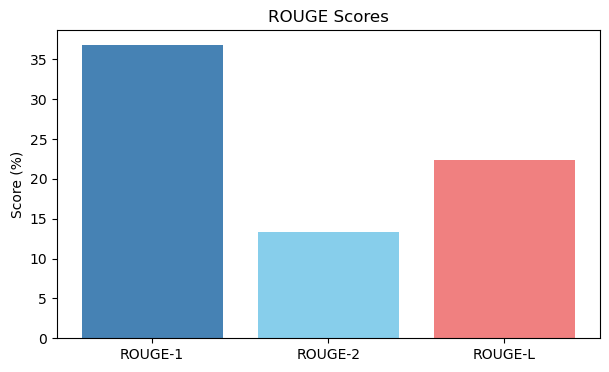

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.bar(["ROUGE-1", "ROUGE-2", "ROUGE-L"], 
        [results["rouge1"], results["rouge2"], results["rougeL"]],
        color=["steelblue", "skyblue", "lightcoral"])
plt.title("ROUGE Scores")
plt.ylabel("Score (%)")
plt.show()

## Notebook Summary

- Loaded fine-tuned BART model.
- Generated summaries on validation set.
- Computed ROUGE and BERTScore metrics.
- Saved results and qualitative examples.

Results saved to: `outputs/eval/`.

Next step (optional): deploy via `app/app.py` to create an interactive summarization demo.